In [64]:
import torch
import os, json
import numpy as np
from src.models.TMT_ENDE_BERT import TMT

class ARGS:
    def __init__(self):
        self.txt = 0
        self.sp = 1
        self.im = 2
        self.bos = 101
        self.eos = 102
        self.pad = 0
        self.mode = 'test'
        self.beam_size = 3
        self.gen_max_len = 256
        self.im_sp = True
        self.im_txt = True
        self.sp_im = True
        self.sp_txt = True
        self.txt_im = True
        self.txt_sp = True

args = ARGS()
model = TMT(args, 203, 30522, 8195)

# Load pre-trained TMT
ckpt = torch.load('data/checkpoints/TMT_BT_COCO.ckpt', map_location='cpu')
model.load_state_dict(ckpt['state_dict'])
model.cuda()
del ckpt

# Load Image Tokenizer
from SEED.models.seed_llama_tokenizer import ImageTokenizer
vq_model = ImageTokenizer(model_path='./pretrained/seed_quantizer.pt', 
                            diffusion_model_path='stabilityai/stable-diffusion-2-1-unclip', 
                            fp16=True, 
                            load_diffusion=True)
vq_model.diffusion_model.enable_xformers_memory_efficient_attention()
vq_model.requires_grad_(False)
vq_model.cuda()

if not os.path.exists('./pretrained/hubert_base_ls960.pt'):
    os.system('wget https://dl.fbaipublicfiles.com/hubert/hubert_base_ls960.pt -P ./pretrained/')
if not os.path.exists('./pretrained/hubert_200_km.bin'):
    os.system('wget https://dl.fbaipublicfiles.com/textless_nlp/gslm/hubert/km200/km.bin -O ./pretrained/hubert_200_km.bin')

from fairseq.examples.textless_nlp.gslm.speech2unit.pretrained.hubert_feature_reader import HubertFeatureReader
ssl_model=HubertFeatureReader(checkpoint_path='./pretrained/hubert_base_ls960.pt', layer=6)

Num_txt_Token: 30522
Num_speech_Token: 203
Num_image_Token: 8195


Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.7.output_query.dense.bias', 'bert.encoder.layer.10.crossattention.output.dense.weight', 'bert.encoder.layer.6.crossattention.self.query.bias', 'bert.encoder.layer.0.output_query.LayerNorm.bias', 'bert.encoder.layer.8.output_query.LayerNorm.weight', 'bert.encoder.layer.10.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.6.crossattention.self.key.bias', 'bert.encoder.layer.8.crossattention.self.query.weight', 'bert.encoder.layer.5.output_query.dense.bias', 'bert.encoder.layer.1.output_query.dense.weight', 'bert.encoder.layer.10.crossattention.self.value.weight', 'bert.encoder.layer.10.crossattention.self.query.bias', 'bert.encoder.layer.2.output_query.dense.weight', 'bert.encoder.layer.4.output_query.dense.bias', 'bert.encoder.layer.6.output_query.LayerNorm.weight', 'bert.encoder.layer.0.output_query.dense.bias', 'bert.encoder.lay

missing keys:  511 unexpected keys: 146


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

In [43]:
@torch.no_grad()
def im_unit_preparation(image_input, vq_model):
    image_tokens = vq_model.encode(image_torch=image_input) # B,T
    return image_tokens

@torch.no_grad()
def im_decode(im_unit, vq_model):
    if not torch.is_tensor(im_unit):
        im_unit = torch.tensor(im_unit)
    images = vq_model.decode(im_unit.cuda())
    return images #list of PIL Image

@torch.no_grad()
def sp_unit_preparation(sp_path, ssl_model, kmeans_model):
    sp_units = []
    sp_unit_len = []

    feat = ssl_model.get_feats(sp_path)
    feat = feat.cpu().numpy()
    pred = kmeans_model.predict(feat)

    #remove repetition
    sp_unit = process_units(pred)
    ### Add special token to speech unit
    sp_unit = add_special_room(sp_unit)
    sp_unit = append_bos(sp_unit)
    sp_unit = append_eos(sp_unit)

    sp_units.append(sp_unit)
    sp_unit_len.append(len(sp_unit))
    
    return sp_units, sp_unit_len

def speech_generation(unit, task='is'):
    ##### Wav Gen #####
    print('Generating WAV from Unit')
    import soundfile as sf
    from fairseq.models.text_to_speech.vocoder import CodeHiFiGANVocoder
    with open('./Vocoder/config.json') as f:
        vocoder_cfg = json.load(f)
    vocoder = CodeHiFiGANVocoder('./Vocoder/g_00950000', vocoder_cfg).cuda()
    
    x = {
        "code": torch.LongTensor(unit).view(1, -1).cuda(),
        }
    with torch.no_grad():
        wav = vocoder(x, True)
    wav_array = wav.detach().cpu().numpy()
    save_name = os.path.join(f'./imgs/{task}.wav')
    if not os.path.exists(os.path.dirname(save_name)):
        os.makedirs(os.path.dirname(save_name))
    sf.write(save_name, wav_array, 16000)
    
    del vocoder, x, wav, wav_array
    return

def process_units(units):
    out = [int(u) for i, u in enumerate(units) if i == 0 or u != units[i - 1]]
    return torch.tensor(out)

def add_special_room(units):
    if torch.is_tensor(units):
        units = units.numpy()
    # orig 0 will be 1 / orig 99 will be 100 / orig 100 will be 103 / orig 101 will be 104
    units[np.where(units >= 100)] += 2 #BOS & EOS room
    units += 1  #PAD room
    return torch.tensor(units)

def del_special_room(units):
    if torch.is_tensor(units):
        units = units.numpy()
    # minus values will be regarded as special tokens
    units[np.where(units == args.pad)] = 0
    units[np.where(units == args.bos)] = 0
    units[np.where(units == args.eos)] = -100
    # 1 will be 0 / 100 will be 99 / 103 will be 100 / 104 will be 101
    units -= 1 #Del PAD room
    units[np.where(units >= 102)] -= 2 #Del BOS & EOS room
    return units

def append_bos(units):
    if len(units.size()) == 2:
        return torch.cat([torch.tensor([args.bos]).unsqueeze(0).repeat(units.size(0), 1), units], 1)
    else:
        return torch.cat([torch.tensor([args.bos]), units], 0)

def append_eos(units):
    if len(units.size()) == 2:
        return torch.cat([units, torch.tensor([args.eos]).unsqueeze(0).repeat(units.size(0), 1)], 1)
    else:
        return torch.cat([units, torch.tensor([args.eos])], 0)

## Image-to-Text & Image-to-Speech

Image->Text:  a green truck driving down a street next to a tall building
Generating WAV from Unit
Removing weight norm...
Image->Speech: 


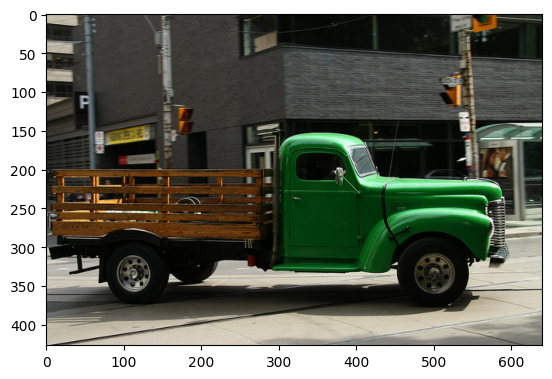

In [26]:
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
from transformers import AutoTokenizer
from test import decode
import IPython

tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

image = Image.open('./imgs/truck.jpg').convert('RGB')
plt.imshow(image)
plt.show()

transform = [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
        ]
transform = transforms.Compose(transform)
image = transform(image).unsqueeze(0)
image.size()

gt_im_unit = im_unit_preparation(image.cuda(), vq_model)

im_unit = add_special_room(gt_im_unit.cpu())
im_unit = append_bos(im_unit)
im_unit = append_eos(im_unit)

output_it = model.forward_task(im_unit.cuda(), None, None, None, input_modal='image', output_modal='text', inference=True)
it_results = tokenizer.batch_decode(output_it.cpu().detach(), skip_special_tokens=True)
print('Image->Text: ', it_results[0])

output_is = model.forward_task(im_unit.cuda(), None, None, None, input_modal='image', output_modal='speech', inference=True)
is_results = output_is[:, 1:].cpu().detach().numpy()
is_results = del_special_room(is_results)
is_results = decode(is_results)
pred_sp_unit = [[int(u) for u in unit.split()] for unit in is_results]

speech_generation(pred_sp_unit[0], task='is')
print("Image->Speech: ")
IPython.display.display(IPython.display.Audio("./imgs/is.wav"))

## Text-to-Image & Speech-to-Image

Input Text:  AN OLD GREEN TRUCK MAKES ITS WAY THROUGH TOWN


  0%|          | 0/21 [00:00<?, ?it/s]

Text->Image: 


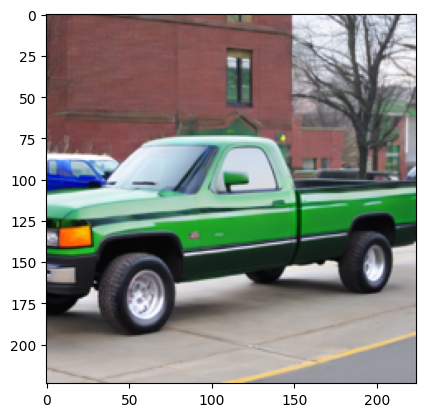

Input Audio: 


/home/ms/miniconda3/envs/torch2.1/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MiniBatchKMeans from version 0.24.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


  0%|          | 0/21 [00:00<?, ?it/s]

Speech->Image: 


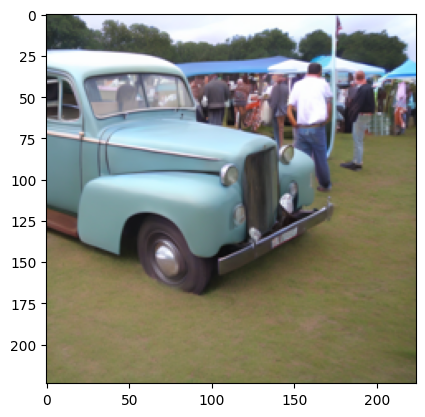

In [59]:

input_txt = "AN OLD GREEN TRUCK MAKES ITS WAY THROUGH TOWN"
print("Input Text: ", input_txt)
txt = tokenizer(text=input_txt, return_tensors="pt").input_ids
txt_len = torch.tensor(txt.size(1)).unsqueeze(0)

output_ti = model.forward_task(txt.cuda(), txt_len, None, None, input_modal='text', output_modal='image', inference=True)
ti_results = output_ti[:, 1:33].cpu().detach().numpy()
ti_results = del_special_room(ti_results)
ti_results[ti_results < 0] = 0
ti_pred_im = im_decode(ti_results[:1], vq_model)

print("Text->Image: ")
plt.imshow(ti_pred_im[0].resize([224,224]))
plt.show()

import joblib
kmeans_model = joblib.load(open("./pretrained/hubert_200_km.bin", "rb"))
kmeans_model.verbose = False
sp_unit, sp_unit_len = sp_unit_preparation('./imgs/truck.wav', ssl_model, kmeans_model)
sp_unit = torch.stack(sp_unit, 0)
sp_unit_len = torch.tensor(sp_unit_len).unsqueeze(0)

print("Input Audio: ")
IPython.display.display(IPython.display.Audio("./imgs/truck.wav"))

output_si = model.forward_task(sp_unit.cuda(), sp_unit_len, None, None, input_modal='speech', output_modal='image', inference=True)
si_results = output_si[:, 1:33].cpu().detach().numpy()
si_results = del_special_room(si_results)
si_results[si_results < 0] = 0
si_pred_im = im_decode(si_results[:1], vq_model)

print("Speech->Image: ")
plt.imshow(si_pred_im[0].resize([224,224]))
plt.show()

## Speech-to-Text & Text-to-Speech

In [65]:
output_st = model.forward_task(sp_unit.cuda(), sp_unit_len, None, None, input_modal='speech', output_modal='text', inference=True)
st_results = tokenizer.batch_decode(output_st.cpu().detach(), skip_special_tokens=True)
print('Speech->Text: ', st_results[0])

output_ts = model.forward_task(txt.cuda(), txt_len, None, None, input_modal='text', output_modal='speech', inference=True)
ts_results = output_ts[:, 1:].cpu().detach().numpy()
ts_results = del_special_room(ts_results)
ts_results = decode(ts_results)
pred_sp_unit = [[int(u) for u in unit.split()] for unit in ts_results]

speech_generation(pred_sp_unit[0], task='ts')
print("Text->Speech: ")
IPython.display.display(IPython.display.Audio("./imgs/ts.wav"))

Speech->Text:  an old green truck next to its way through town
Generating WAV from Unit


/home/ms/miniconda3/envs/torch2.1/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Removing weight norm...
Text->Speech: 
